In [1]:
def Ht_regularization(H, mesh, boundary):
    normal = specialcf.normal(mesh.dim)
    fesu = H1(mesh, order=feorder, definedon=mesh.Boundaries(total_boundary), complex=False)
    u, v= fesu.TnT()
    a = BilinearForm(fesu)
    a +=Cross(normal,grad(u).Trace())*Cross(normal, grad(v).Trace())*ds
    f=LinearForm(fesu)
    f +=-H*Cross(normal, grad(v).Trace())*ds
    with TaskManager():
        a.Assemble()
        f.Assemble()
    gfu=GridFunction(fesu)
    gfu=solver.iccg_solve(fesu, gfu, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=False, logplot=True) 
    hreg=H+Cross(normal,grad(gfu).Trace())
    return hreg

In [2]:
from ngsolve import *
from netgen.meshing import meshsize
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
cpp_solver="EMPY"
#cpp_solver="JP_MARs"
sys.path.append('..\model')
from BathPlateModel import BathPlateModel

#model=BathPlateModel(holes=2,outerBox="sphere", boxx=0.2, div_thick=1)
model=BathPlateModel(holes=2, outerBox="box", boxx=0.2, boxy=0.2, boxz=0.2, msize=meshsize.coarse)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 2    Thickness: 0.00635
boxx=  0.2  boxy=  0.2  boxz=  0.2
div_thick=  1
name: conductor   mass: 2.6669999999999994e-05   center: (0, 2.1808e-20, -2.46491e-21)
name: air   mass: 0.00017348625000000007   center: (0, -4.55112e-19, 2.91247e-20)
name: reduced_region   mass: 0.06379984375000002   center: (0, -1.44176e-19, 9.03322e-20)
conductive_region: conductor
Conductor boundary: conductor_boundary
{'conductor': 32780000.0, 'air': 0, 'reduced_region': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced_region': 1.2566370614359173e-06, 'default': 1.2566370614359173e-06}
class HolePot: num= 0  holes
class MeasureFace: num= 0  faces


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [3]:
import math
feorder=3
Dirichlet=False
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
    

enter iccg_solve
Dof= 1964    Nonzeros= 33254
shift parameter= 1.0
minimum residual= 6.0379304610688206e-12  at iteraions:  31


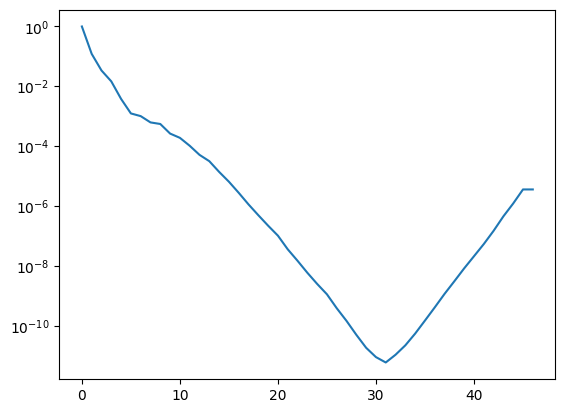

ICCG calculation time (sec): 0.004155499998887535
enter iccg_solve
Dof= 93691    Nonzeros= 5474886
shift parameter= 1.06
minimum residual= 2.231997847699384e-15  at iteraions:  117


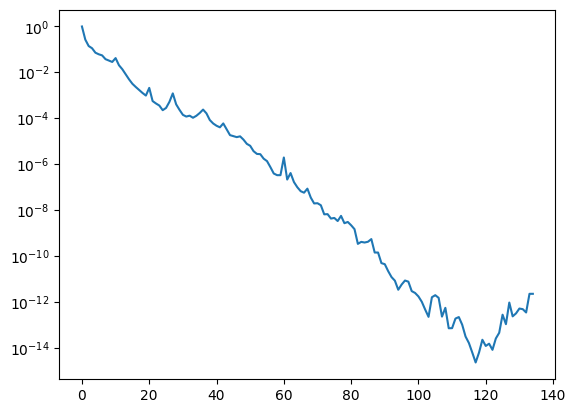

ICCG calculation time (sec): 4.204989599995315


In [4]:
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
symmetric_plane=model.symmetric_plane
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

coil=model.coil.field
#coil=UNIF(0,0,0.01,0)
As=Afield(coil)
Bs=Bfield(coil)
mu=4.e-7*math.pi
Hs=Bs/mu
Asr=model.ReducedField(As, (0,0,0))
Bsr=model.ReducedField(Bs, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True, complex=jomega)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True, complex=jomega) 
fesPhi=H1(mesh, order=feorder, definedon=conductive_region, complex=jomega) 
fesAPhi=fesA*fesPhi
(A,phi), (N, psi) = fesAPhi.TnT() 
gfAPhi = GridFunction(fesAPhi)
gfA, gfPhi=gfAPhi.components

normal = specialcf.normal(mesh.dim)
a= BilinearForm(fesAPhi)
a +=1/Mu*curl(A)*curl(N)*dx
a +=s*Sigma*(A+grad(phi))*(N+grad(psi))*dx(conductive_region)
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(As, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesAPhi)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)

with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesAPhi.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesAPhi.FreeDofs()] = fcut

# Add Neumann condition terms
hst=Ht_regularization(Hs, mesh, total_boundary)
#f += Cross(N.Trace(),Hs)*normal*ds(total_boundary)
f += Cross(N.Trace(),hst)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfAPhi= GridFunction(fesAPhi)   #Clear gfA
gfA, gfPhi=gfAPhi.components
gfAPhi=solver.iccg_solve(fesAPhi, gfAPhi, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, 
                         logplot=True, complex=jomega, cpp_solver=cpp_solver) 

fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
At=GridFunction(fesAt)
Ar=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Ar.Set(gfA,VOL, definedon=reduced_region)
Ar.Set(gfA-As, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Br=curl(Ar)

Afield=At+Ar+Asr
Bfield=Bt+Br+Bsr
Jfield=-s*Sigma*(At+grad(gfPhi))


In [5]:
mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))

if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

center magnetic field =  ((0.004599877180284334-0.0002210469234715925j), (6.820119192259008e-06+2.538267392960301e-05j), (0.007142488600931125-0.0016938770017841586j))
 Average Joule loss=  0.24910502914759097


In [6]:
from netgen.occ import OCCGeometry
from ngsolve.comp import Mesh
from netgen.meshing import meshsize
#plotMesh=Mesh(OCCGeometry(model.conductor).GenerateMesh(meshsize.coarse)).Curve(1)

In [7]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh,order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    #print("****** Bfield ******")
    #Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

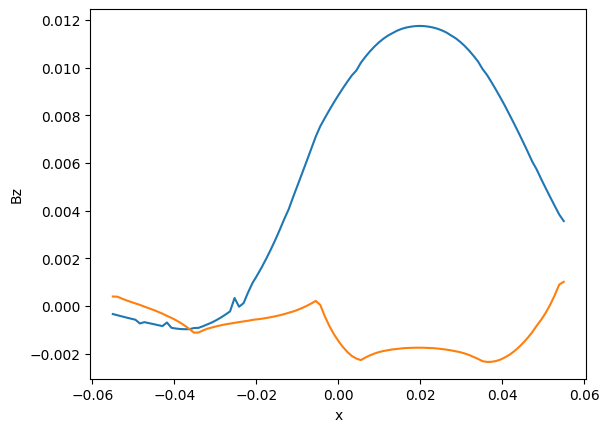

In [8]:
import matplotlib.pylab as plt
x0=0.055
y0=0
z0=6.35e-3/2+0.5e-3
dx=2*x0/100
x=x0
y=y0
z=z0
xp=[]
ypreal=[]
ypimag=[]
for n in range(101):
    pnt=mesh(x,y,z)
    #print( "x= ", x, "  Bz= ", Bfield(pnt)[2].real, "  ", Bfield(pnt)[2].imag)
    xp.append(x)
    ypreal.append(Bfield(pnt)[2].real)
    ypimag.append(Bfield(pnt)[2].imag)
    x=x-dx

plt.plot(xp, ypreal )  
plt.xlabel("x")  # Add x-axis label
#plt.ylabel("Bz")  # Add y-axis label
plt.plot(xp, ypimag ) 
plt.xlabel("x")  # Add x-axis label
plt.ylabel("Bz")  # Add y-axis label
plt.show()  

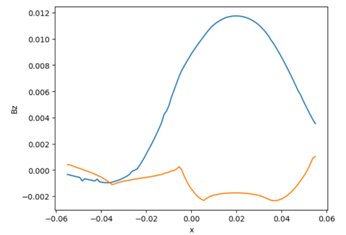

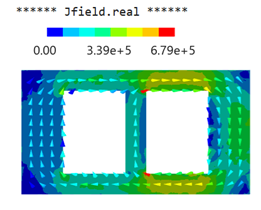
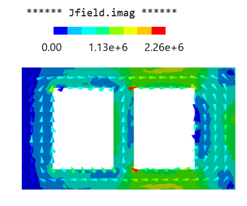

Average Joule loss=  0.24937612294051162